In [139]:
import spacy
import numpy as np
import pandas as pd
from collections import Counter
from wordfreq import word_frequency
import scipy
import matplotlib.pyplot as plt 

In [12]:
header_names = ['HIT ID', 'Sentence', 'Start word', 'End word', 'Target word', 'Native', 'Non-native', 'Difficult native',
         'Difficult non', 'Binary', 'Prob']

In [15]:
tsv_data = pd.read_csv('data/original/english/WikiNews_Train.tsv', sep='\t', header = 0, names = header_names)

In [104]:
'''
At least one native or non-native thought it was difficult
'''
temp_data = tsv_data.loc[(tsv_data["Difficult native"] >= 1) | (tsv_data["Difficult non"] >= 1)]

In [109]:
'''
Fuck pandas
'''
clean = temp_data
lengths = []
for i in range(len(temp_data)):
    if len(clean["Target word"].iloc[i].split(' ')) == 1:
        lengths.append(1)
    else:
        lengths.append(0)

clean['lengths'] = lengths

clean = clean.loc[(clean['lengths'] == 1)]

C:\Users\sebas\AppData\Local\Temp\ipykernel_8696\1724494000.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean['lengths'] = lengths


In [143]:
'''
Calculate word length and compute correlation with probabilistic complexity
'''
wordcor = []

for i in range(len(clean)):
    wordcor.append(word_frequency(clean['Target word'].iloc[i], 'en', minimum = 0.0))

In [225]:
'''
Calculate word length and compute correlation with probabilistic complexity
'''
wordcor = []
postags = []

for i in range(len(clean)):
    
    #pos tagging
    for token in nlp(clean['Sentence'].iloc[i]):
        if token.text ==clean['Target word'].iloc[i]:
            pos=token.pos_
            postags.append([pos, clean['Prob'].iloc[i]])
            break
                
    wordcor.append([len(clean['Target word'].iloc[i]), 
                    word_frequency(clean['Target word'].iloc[i], 'en', minimum = 0.0),
                    clean['Prob'].iloc[i]])


In [197]:
# x is word length, y is probabilistic complexity
word_length = np.array(wordcor).T[0]
word_freq = np.array(wordcor).T[1]
prob_complex = np.array(wordcor).T[2]

In [198]:
print(f"Pearson Correlation length vs complexity: {scipy.stats.pearsonr(word_length, prob_complex)[0]}")
print(f"Pearson Correlation frequency vs complexity: {scipy.stats.pearsonr(word_freq, prob_complex)[0]}")

Pearson Correlation length vs complexity: 0.2818309268002792
Pearson Correlation frequency vs complexity: -0.29798346346415117


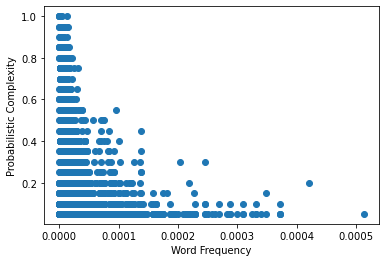

In [199]:
plt.scatter(word_freq, prob_complex)
plt.xlabel("Word Frequency")
plt.ylabel("Probabilistic Complexity")
plt.show()

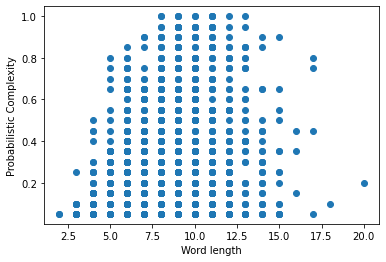

In [200]:
plt.scatter(word_length, prob_complex)
plt.xlabel("Word length")
plt.ylabel("Probabilistic Complexity")
plt.show()

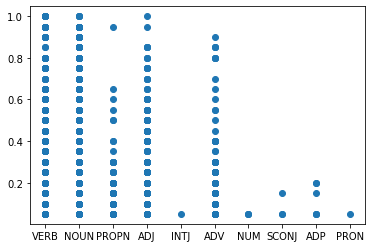

In [236]:
plt.scatter(np.array(postags).T[0], np.array(postags).T[1].astype('float'))
plt.show()